# *Aufgabe: Advanced Metriken and Hypereparameteroptimierung*

0. Imports

In [12]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from tqdm import trange

### Aufgabe 1. Advanced Metrics

1. Import and Train/Test split

In [13]:
census = pd.read_csv("../../../data/census.csv")
census = census.drop(['occupation', 'relationship', 'capital-gain', 'capital-loss', 'native-country', 'workclass', 'marital-status'], axis=1)

# Missing Values: 'workclass'

#imp_most_frequent = SimpleImputer(missing_values=' ?', strategy='most_frequent')
#census['workclass'] = imp_most_frequent.fit_transform(census['workclass'].to_numpy().reshape(-1,1))

# Encoding:
# SEX: Male: 1, Female: 0
census["sex"] = census["sex"].replace({' Male': 1, ' Female': 0})

# TARGET: >50K: 1, <=50K: 0 
census["target"] = census["target"].replace({' >50K': 1, ' <=50K': 0})

to_encode = ['education', 'race']
for feature in to_encode:
    one_hot = pd.get_dummies(census[feature], drop_first=True)
    census = census.join(one_hot)
    census.pop(feature)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(census.drop(["target"],axis=1),census["target"])
print('X Train: {}'.format(x_train.shape)) 
print('Y Train: {}'.format(y_train.shape)) 
print('X Test: {}'.format(x_test.shape)) 
print('Y Test: {}'.format(y_test.shape))

# Normalize: Age und hours-per-week
minmax = MinMaxScaler()

x_train['age'] = minmax.fit_transform(x_train['age'].to_numpy().reshape(-1,1))
x_train['hours-per-week'] = minmax.fit_transform(x_train['hours-per-week'].to_numpy().reshape(-1,1))

x_test['age'] = minmax.fit_transform(x_test['age'].to_numpy().reshape(-1,1))
x_test['hours-per-week'] = minmax.fit_transform(x_test['hours-per-week'].to_numpy().reshape(-1,1))

X Train: (24420, 22)
Y Train: (24420,)
X Test: (8141, 22)
Y Test: (8141,)


2. Train the Random Forest and kNN models:

--------------------------------- 
 TRIVIALE HYPOTHESE
Accuracy: 0.7639110674364329
Confusion matrix: 
[[6219 1922]
 [   0    0]]
--------------------------------- 
 RANDOM FOREST  
Accuracy: 0.7639110674364329
Confusion matrix: 
[[6219 1922]
 [   0    0]]
Precision: 0.0
Recall: nan


/var/folders/vx/hcm3xqr533g30kd_72jn3qb40000gn/T/ipykernel_12501/2486396959.py:25: RuntimeWarning: invalid value encountered in long_scalars
  print("Recall: {}".format(tp/(tp + fn)))


--------------------------------- 
 KNN  
Accuracy: 0.8087458543176514
Confusion matrix: 
[[5781 1119]
 [ 438  803]]
Precision: 0.4177939646201873
Recall: 0.6470588235294118


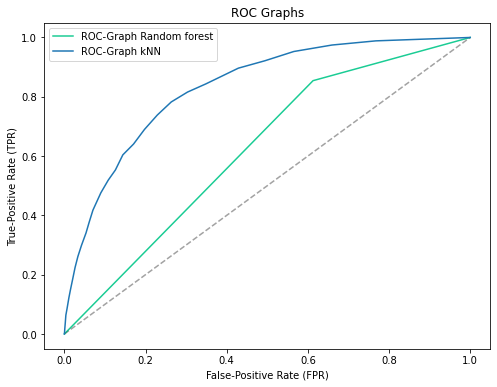

In [15]:
# Triviale Hypothese

predict = np.zeros(len(y_test))

cm = confusion_matrix(predict, y_test)
tn, fp, fn, tp = cm.ravel()

print("--------------------------------- \n TRIVIALE HYPOTHESE")
print("Accuracy: {}".format(accuracy_score(predict, y_test)))
print("Confusion matrix: \n{}".format(cm))    

# Random Forest:

rf = RandomForestClassifier(n_estimators=2, criterion="entropy", max_depth=1, min_samples_split=5, random_state=1)
rf.fit(x_train, y_train)
predict = rf.predict(x_test)

cm = confusion_matrix(predict, y_test)
tn, fp, fn, tp = cm.ravel()

print("--------------------------------- \n RANDOM FOREST  ")
print("Accuracy: {}".format(accuracy_score(predict, y_test)))
print("Confusion matrix: \n{}".format(cm))    
print("Precision: {}".format(tp/(tp + fp)))
print("Recall: {}".format(tp/(tp + fn)))    

plt.figure(figsize=(8,6))
plt.title("ROC Graphs")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, rf.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="black",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph Random forest",c="#1ACC94")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")

# kNN
knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(x_train, y_train)
predict = knn.predict(x_test)

cm = confusion_matrix(predict, y_test)
tn, fp, fn, tp = cm.ravel()

print("--------------------------------- \n KNN  ")
print("Accuracy: {}".format(accuracy_score(predict, y_test)))
print("Confusion matrix: \n{}".format(cm))    
print("Precision: {}".format(tp/(tp + fp)))
print("Recall: {}".format(tp/(tp + fn)))    
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, knn.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="black",alpha=0.2)
plt.plot(fpr,tpr,label="ROC-Graph kNN")

plt.legend()
plt.show()

### Aufgabe 2. Hyperparameteroptimierung

1. Optimize Random Forest with Grid Search Algorithm

In [17]:
grid_points_n_estimators = trange(1, 201, 50)
grid_points_max_depth = np.arange(1, 11)
grid_points_min_samples_split = np.arange(2, 52, 5)

max_z = -np.inf
best_point = (1, 1, 2)
for n_estimators in grid_points_n_estimators:
    for max_depth in grid_points_max_depth:
        for min_samples_split in grid_points_min_samples_split:
            rf = RandomForestClassifier(n_estimators=n_estimators, criterion="entropy", max_depth=max_depth, 
                                        min_samples_split=min_samples_split, random_state=1)
            rf.fit(x_train, y_train)
            z = accuracy_score(rf.predict(x_test), y_test)
            #print(z, max_z, best_point, (n_estimators, max_depth, min_samples_split))
            if z > max_z:
                max_z = z
                best_point = (n_estimators, max_depth, min_samples_split)
        
print("Bester Punkt mit z={:.3f} gefunden bei {}".format(max_z, best_point))        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:44<00:00, 41.15s/it]

Bester Punkt mit z=0.813 gefunden bei (151, 9, 37)


2. ROC Graph and confusion matrix:

Accuracy: 0.8134135855546002
Confusion matrix: 
[[5957 1257]
 [ 262  665]]
Precision: 0.34599375650364206
Recall: 0.7173678532901834


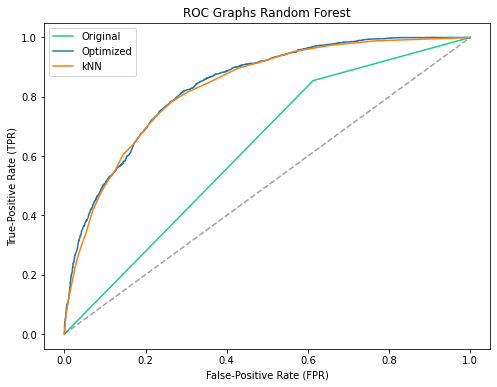

In [18]:
# Original model

rf1 = RandomForestClassifier(n_estimators=2, criterion="entropy", max_depth=1, min_samples_split=5, random_state=1)
rf1.fit(x_train, y_train)
predict = rf.predict(x_test)

plt.figure(figsize=(8,6))
plt.title("ROC Graphs Random Forest")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, rf1.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="black",alpha=0.2)
plt.plot(fpr,tpr,label="Original",c="#1ACC94")
plt.xlabel("False-Positive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR)")

# Optimized model
rf_opt = RandomForestClassifier(n_estimators=best_point[0], criterion="entropy", max_depth=best_point[1], 
                                min_samples_split=best_point[2], random_state=1)
rf_opt.fit(x_train, y_train)
predict = rf_opt.predict(x_test)

cm = confusion_matrix(predict, y_test)
tn, fp, fn, tp = cm.ravel()

print("Accuracy: {}".format(accuracy_score(predict, y_test)))
print("Confusion matrix: \n{}".format(cm))    
print("Precision: {}".format(tp/(tp + fp)))
print("Recall: {}".format(tp/(tp + fn)))    
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, rf_opt.predict_proba(x_test)[:,1:])
plt.plot(fpr,tpr,label="Optimized")

fpr, tpr, thresholds = metrics.roc_curve(y_test.values, knn.predict_proba(x_test)[:,1:])
plt.plot([0,1],[0,1],ls="--",c="black",alpha=0.2)
plt.plot(fpr,tpr,label="kNN")
plt.legend()
plt.show()